Goal is to estimate the mining return over the life of the project.
Estimate the fuel cost that the project can bear.


Remember, you can calculate the implied network hashrate based on the difficulty:

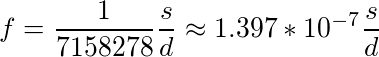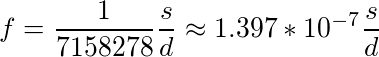

From: https://medium.com/chainalysis/bitcoin-mining-calculations-ff90dc958dba



$$btc\_day = {hashrate \over network hashrate} * \left( {block reward \over blocks per day} + Network Fees \right) $$

$$ {btc \over block}{ 1 \over time to mine a block}$$

$$ {btc \over block} {yourhashrate \over difficulty * 2^{32}} $$

1. Difficulty Function
2. btc_day Function
3. Time to find a block

In [6]:
import pint
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Extra unit definitions
ureg = pint.UnitRegistry()
ureg.define('dollar = 1')
ureg.define('hash = 1')
ureg.define('block = 1')
ureg.define('btc = 1')



In [11]:
def diff_func(d_now, t, r = 0.0075):
    '''
    Difficulty function used to estimate the difficulty t days in the future based on the current difficulty d_now
    parameter r is given from medium link above.
    '''
    return d_now * (1 + r)**t

def btc_day(hashrate, network_hashrate, block_reward, fees):
    '''
    Calculate the approximate number of btc mined per day based on your hashrate, the network hashrate, the block reward and the fees / day
    '''
    # By some magic, on average a block is mined every 10 minutes.  Producing 144 blocks per day
    blocksperday = (1 * ureg.block / (10 * ureg.min)) * (60 * ureg.min / ureg.hour) * (24 * ureg.hour / ureg.day)
    # Extra step needed here for unit conversion
    ret = (hashrate / network_hashrate) * ((block_reward * blocksperday) + fees)
    return ret.to('btc/day')

def timetofindblock(difficulty, hashrate):
    '''
    This is a way to estimate your time to mine a block based on your hashrate and the current difficulty.  Which is another way to derive your daily revenue.  
    I think it's not as accurate because the difficulty always lags the network hashrate.
    '''
    return (difficulty * 2**32) / hashrate

def implied_hashrate(difficulty, s):
    '''
    Function to calculate the network hashrate based on a given difficulty
    '''
    return (1 / 7158278) * (s / difficulty)
    
#diff_func(14363025673660, 0.0075, 1)
#print(btc_day(hashrate, network_hashrate, block_reward, avg_fees))
#round(timetofindblock(difficulty, hashrate).to('sec') * (ureg.min / (60 * ureg.sec)) * (ureg.hour / (60 * ureg.min)) * (ureg.day / (24 * ureg.hour)))
#secperday = print(60 * ureg.sec / ureg.min * 60 * ureg.min / ureg.hour * 24 * ureg.hour / ureg.day);


In [13]:
hashrate = 100 * ureg.terahash / ureg.sec
network_hashrate = 97494534728710730000 * ureg.hash / ureg.sec
block_reward = 6.25 * ureg.btc / ureg.block
blocksperday = (1 * ureg.block / (10 * ureg.min)) * (60 * ureg.min / ureg.hour) * (24 * ureg.hour / ureg.day)
difficulty = 14363025673660 * ureg.hash
avg_fees = 90 * ureg.btc / ureg.day



14437887774890.43


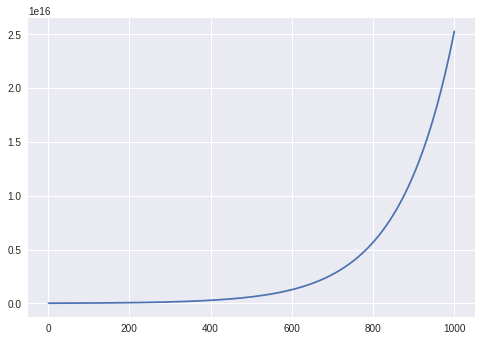

In [14]:
x = np.linspace(1, 1000, num = 1000)
y = diff_func(14363025673660, x)

print(diff_func(14363025673660, 0.0075, 1))

plt.plot(x,y)

In [22]:
#Need to move this into a database and maybe do some web scraping

#Antminer S9
power = 1600 * ureg.watt
hashrate = 14 * ureg.terahash / ureg.sec
cost = 600 * ureg.dollar

print(hashrate / power)
print(hashrate / cost)

#Antminer S19J pro
power = 3250 * ureg.watt
hashrate = 104 * ureg.terahash / ureg.sec
cost = 7900 * ureg.dollar

print(hashrate / power)
print(hashrate / cost)

0.00875 terahash / second / watt
0.023333333333333334 terahash / dollar / second
0.032 terahash / second / watt
0.013164556962025316 terahash / dollar / second


# Generator Calculations
So maybe the task is to write some functions to say ok this fuel cost equates to this elec rate in cents / kwh

In [9]:
#some functions
def gencost_kwh(size, cost, lifespan):
    '''
    Gives you the cost to run a given generator in dollars / KWh
    Useful for comparison to hosting center electricity rates
    '''
    return (cost / size) / lifespan * (ureg.year / (365 * ureg.day)) * (ureg.day / (24 * ureg.hour))

# Some constants
generator_rated_load = 60 * ureg.kilowatt
generator_fuel_gas_consumption = 800 * ureg.cubic_foot / ureg.hour

#National average is something like 12 c/kwh, LA like 9 c/kwh
elec_cost = 0.10 * ureg.dollar / ureg.kilowatt_hour
elec_cost_ind = 0.065 * ureg.dollar / ureg.kilowatt_hour
#Average industrial cost for gas is something like $2-3 / mcf
fuel_cost = 1 * ureg.dollar / ureg.cubic_foot / 1000

print(generator_rated_load)
print(generator_fuel_gas_consumption)

60 kilowatt
800.0 cubic_foot / hour


1.001.001.00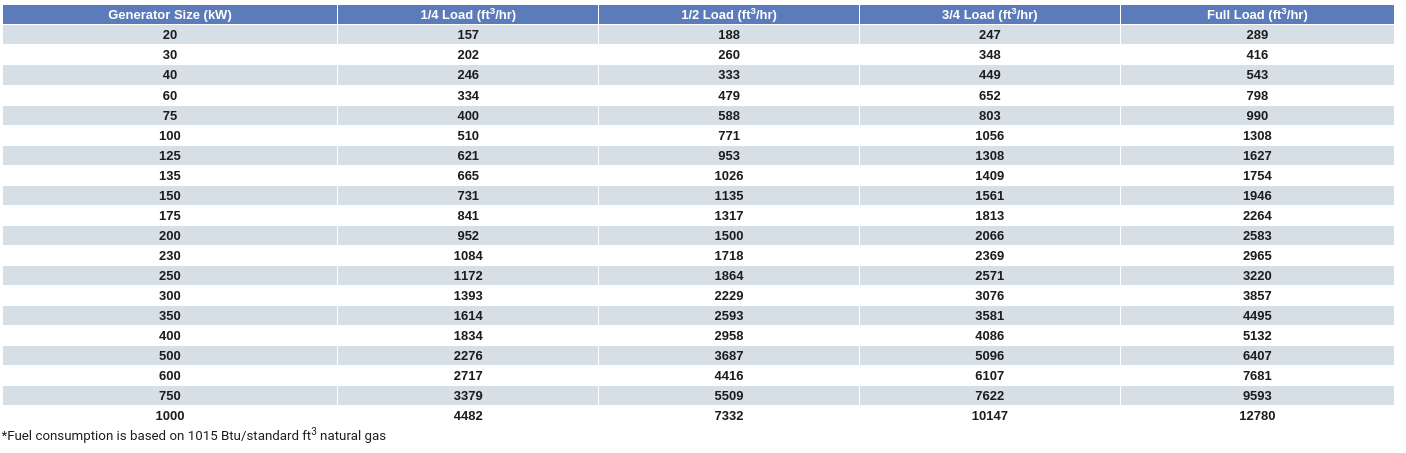

From: https://www.generatorsource.com/Natural_Gas_Fuel_Consumption.aspx'

Flaring report + Map: https://www.energy.gov/sites/prod/files/2019/08/f65/Natural%20Gas%20Flaring%20and%20Venting%20Report.pdf

In [126]:
fuel_cost * generator_fuel_gas_consumption * (24 * ureg.hour / ureg.day) * (365 * ureg.day / ureg.year)

7008.000000000001 <Unit('dollar / year')>

In [118]:
cost_kwh.to('dollar / ( year kilowatt)') * 60

3252.22602739726 <Unit('dollar / kilowatt / year')>

In [14]:
#Cost to run the genny on industrial fuel gas
print(round(fuel_cost * generator_fuel_gas_consumption * 24 * ureg.hour / ureg.day * 30 * ureg.day / ureg.month))

1152.0 dollar / month


In [110]:
#Cost to operate the mining equipment in a hosting center
#cost = generator_rated_load * elec_cost * 24 * ureg.hour / ureg.day * 30 * ureg.day / ureg.month
#print(cost.to('dollar/month'))
cost = generator_rated_load * elec_cost_ind * 24 * ureg.hour / ureg.day * (365 * ureg.day / ureg.year)
print(round(cost.to('dollar/year')))

34164.0 dollar / year


In [130]:
gen_cost = 13000 * ureg.dollar
proj_lifespan = 4 * ureg.year

gencost_kwh(generator_rated_load, gen_cost, proj_lifespan)

0.006183409436834094 <Unit('dollar / hour / kilowatt')>

In [15]:
implied_hashrate(14363025673660, )

9.726251661684448e-21